In [1]:
import numpy as np
import pandas as pd
import pytorch_lightning as pl

import torch

# We also set the logging level so that we get some feedback from the API

import logging
logging.basicConfig(level=logging.INFO)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.set_float32_matmul_precision('medium')

## 1. Download

In [2]:
from icenet.data.sic.mask import Masks
from icenet.data.sic.osisaf import SICDownloader

### Mask data

Create masks for masking data.

In [3]:
masks = Masks(north=False, south=True)
masks.generate(save_polarhole_masks=False)

INFO:root:Skipping ./data/masks/south/masks/active_grid_cell_mask_01.npy, already exists
INFO:root:Skipping ./data/masks/south/masks/active_grid_cell_mask_02.npy, already exists
INFO:root:Skipping ./data/masks/south/masks/active_grid_cell_mask_03.npy, already exists
INFO:root:Skipping ./data/masks/south/masks/active_grid_cell_mask_04.npy, already exists
INFO:root:Skipping ./data/masks/south/masks/active_grid_cell_mask_05.npy, already exists
INFO:root:Skipping ./data/masks/south/masks/active_grid_cell_mask_06.npy, already exists
INFO:root:Skipping ./data/masks/south/masks/active_grid_cell_mask_07.npy, already exists
INFO:root:Skipping ./data/masks/south/masks/active_grid_cell_mask_08.npy, already exists
INFO:root:Skipping ./data/masks/south/masks/active_grid_cell_mask_09.npy, already exists
INFO:root:Skipping ./data/masks/south/masks/active_grid_cell_mask_10.npy, already exists
INFO:root:Skipping ./data/masks/south/masks/active_grid_cell_mask_11.npy, already exists
INFO:root:Skipping ./

### Climate and Sea Ice data

Download climate variables from ERA5 and sea ice concentration from OSI-SAF.

In [4]:
sic = SICDownloader(
    dates=[pd.to_datetime(date).date() for date in
           pd.date_range("2020-01-01", "2020-04-30", freq="D")],
    delete_tempfiles=False,
    north=False,
    south=True,
    parallel_opens=False,
)

sic.download()

INFO:root:Downloading SIC datafiles to .temp intermediates...
INFO:root:Excluding 121 dates already existing from 121 dates requested.
INFO:root:Opening for interpolation: ['./data/osisaf/south/siconca/2020.nc']
INFO:root:Processing 0 missing dates


## 2. Data Processing

Process downloaded datasets.

To make life easier, setting up train, val, test dates.

In [5]:
processing_dates = dict(
    train=[pd.to_datetime(el) for el in pd.date_range("2020-01-01", "2020-03-31")],
    val=[pd.to_datetime(el) for el in pd.date_range("2020-04-03", "2020-04-23")],
    test=[pd.to_datetime(el) for el in pd.date_range("2020-04-01", "2020-04-02")],
)
processed_name = "notebook_api_pytorch_data"

Next, we create the data producer and configure them for the dataset we want to create.

In [6]:
from icenet.data.processors.era5 import IceNetERA5PreProcessor
from icenet.data.processors.meta import IceNetMetaPreProcessor
from icenet.data.processors.osi import IceNetOSIPreProcessor

osi = IceNetOSIPreProcessor(
    ["siconca"],
    [],
    processed_name,
    processing_dates["train"],
    processing_dates["val"],
    processing_dates["test"],
    linear_trends=tuple(),
    north=False,
    south=True
)

meta = IceNetMetaPreProcessor(
    processed_name,
    north=False,
    south=True
)

Next, we initialise the data processors using `init_source_data` which scans the data source directories to understand what data is available for processing based on the parameters. Since we named the processed data `"notebook_api_data"` above, it will create a data loader config file, `loader.notebook_api_data.json`, in the current directory.

In [7]:
osi.init_source_data(
    lag_days=1,
)
osi.process()

meta.process()

INFO:root:Processing 91 dates for train category
INFO:root:Including lag of 1 days
INFO:root:Including lead of 93 days
INFO:root:No data found for 2019-12-31, outside data boundary perhaps?
INFO:root:Processing 21 dates for val category
INFO:root:Including lag of 1 days
INFO:root:Including lead of 93 days
INFO:root:Processing 2 dates for test category
INFO:root:Including lag of 1 days
INFO:root:Including lead of 93 days
INFO:root:Got 1 files for siconca
INFO:root:Opening files for siconca
INFO:root:Filtered to 121 units long based on configuration requirements
INFO:root:No normalisation for siconca
INFO:root:Loading configuration ./loader.notebook_api_pytorch_data.json
INFO:root:Writing configuration to ./loader.notebook_api_pytorch_data.json
INFO:root:Loading configuration ./loader.notebook_api_pytorch_data.json
INFO:root:Writing configuration to ./loader.notebook_api_pytorch_data.json


At this point the preprocessed data is ready to convert or create a configuration for the network dataset.

### Dataset creation

As with the `icenet_dataset_create` command we can create a dataset configuration for training the network. As before this can include cached data for the network in the format of a TFRecordDataset compatible set of tfrecords. To achieve this we create the `IceNetDataLoader`, which can both generate `IceNetDataSet` configurations (which easily provide the necessary functionality for training and prediction) as well as individual data samples for direct usage.

In [8]:
from icenet.data.loaders import IceNetDataLoaderFactory

implementation = "dask"
loader_config = "loader.notebook_api_pytorch_data.json"
dataset_name = "notebook_api_pytorch_data"
lag = 1

dl = IceNetDataLoaderFactory().create_data_loader(
    implementation,
    loader_config,
    dataset_name,
    lag,
    n_forecast_days=7,
    north=False,
    south=True,
    output_batch_size=1,
    generate_workers=4)

INFO:root:Loading configuration loader.notebook_api_pytorch_data.json


At this point we can either use `generate` or `write_dataset_config_only` to produce a ready-to-go `IceNetDataSet` configuration. Both of these will generate a dataset config, `dataset_config.notebook_api_pytorch_data.json` (recall we set the dataset name as `notebook_api_pytorch_data` above).

In this case, for pytorch, will read data in directly, rather than using cached tfrecords inputs.

In [9]:
dl.write_dataset_config_only()

INFO:root:Writing dataset configuration without data generation
INFO:root:91 train dates in total, NOT generating cache data.
INFO:root:21 val dates in total, NOT generating cache data.
INFO:root:2 test dates in total, NOT generating cache data.
INFO:root:Writing configuration to ./dataset_config.notebook_api_pytorch_data.json


We can now create the IceNetDataSet object:

In [10]:
from icenet.data.dataset import IceNetDataSetPyTorch
dataset_config = f"dataset_config.{dataset_name}.json"

In [11]:
train_dataset = IceNetDataSetPyTorch(dataset_config, mode="train")
val_dataset = IceNetDataSetPyTorch(dataset_config, mode="val")

INFO:root:Loading configuration dataset_config.notebook_api_pytorch_data.json
INFO:root:Loading configuration /Users/npedrazzini/Desktop/ice-station-zebra/notebook/loader.notebook_api_pytorch_data.json
INFO:root:Loading configuration dataset_config.notebook_api_pytorch_data.json
INFO:root:Loading configuration /Users/npedrazzini/Desktop/ice-station-zebra/notebook/loader.notebook_api_pytorch_data.json


In [12]:
len(train_dataset[0])

3

In [13]:
sample = train_dataset[0]  # Or val_dataset[0]
X, y, mask = sample

print(f"X type: {type(X)}")       # Expect torch.Tensor or np.ndarray
print(f"y type: {type(y)}")
print(f"mask type: {type(mask)}")


X type: <class 'numpy.ndarray'>
y type: <class 'numpy.ndarray'>
mask type: <class 'numpy.ndarray'>


## Check what's in the train data

In [14]:
train_dataset[0][0].shape  # (H, W, C) --> training input

(432, 432, 4)

In [15]:
train_dataset.channels

['siconca_abs_1', 'cos_1', 'land_1', 'sin_1']

In [16]:
train_dataset[0][1].shape  # (H, W, T, C) --> target to predict

(432, 432, 7, 1)

In [17]:
train_dataset[0][2].shape  # (H, W, T, C) --> land mask

(432, 432, 7, 1)

X.shape: (432, 432, 4)
y.shape: (432, 432, 7, 1)
mask.shape: (432, 432, 7, 1)


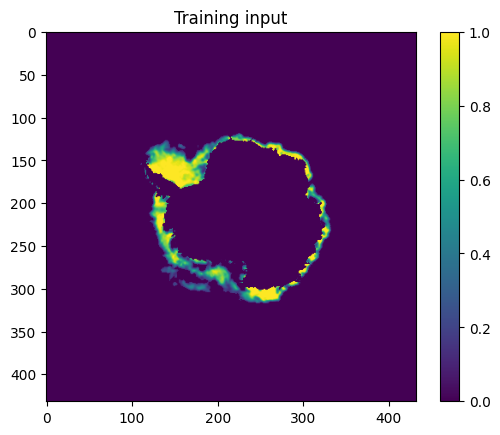

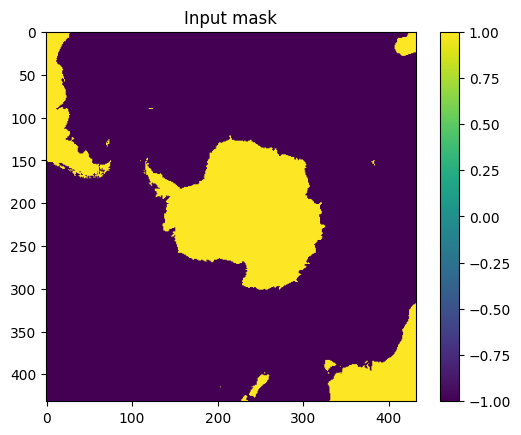

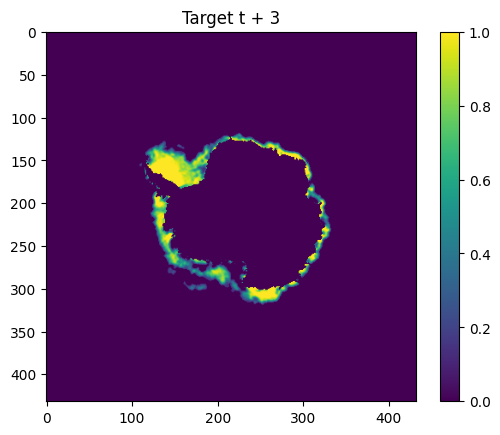

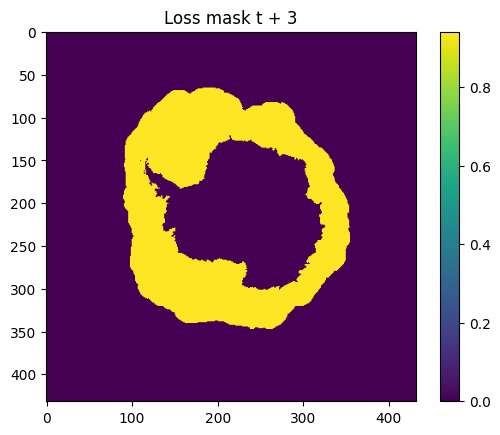

In [18]:
X, y, mask = train_dataset[13]

print("X.shape:", X.shape)       # (432, 432, 4)
print("y.shape:", y.shape)       # (432, 432, 7, 1)
print("mask.shape:", mask.shape) # (432, 432, 7, 1)

# Look at a specific channel
import matplotlib.pyplot as plt

plt.imshow(X[:, :, 0])  # input SIC t
plt.title("Training input")
plt.colorbar()
plt.show()

plt.imshow(X[:, :, 2])  # input mask t
plt.title("Input mask")
plt.colorbar()
plt.show()

plt.imshow(y[:, :, 3, 0])  # target SIC t+3
plt.title("Target t + 3")
plt.colorbar()
plt.show()

plt.imshow(mask[:, :, 3, 0])  # mask t+3
plt.title("Loss mask t + 3")
plt.colorbar()
plt.show()


## Define Persistence Model

In [19]:
train_dataset[0][0][:,:,0].shape

(432, 432)

In [ ]:
import torch
import numpy as np

class PersistenceModel:
    def __init__(self, forecast_steps):
        self.forecast_steps = forecast_steps

    def __call__(self, X):
        if isinstance(X, np.ndarray):
            X = torch.from_numpy(X).float()

        if X.ndim == 3:  # (H, W, C), add batch dimension
            X = X.unsqueeze(0)

        # X: (B, H, W, C), use channel 0
        sic = X[..., 0]                          # (B, H, W)
        sic = sic.unsqueeze(1).unsqueeze(2)     # (B, 1, 1, H, W)
        y_hat = sic.repeat(1, self.forecast_steps, 1, 1, 1)  # (B, T, 1, H, W)
        return y_hat


In [ ]:
class PersistenceLightningModule(pl.LightningModule):
    def __init__(self, forecast_steps=7):
        super().__init__()
        self.automatic_optimization = False # No optimizer needed for persistence, but LighningModule will still call it by default
        self.model = PersistenceModel(forecast_steps)

    def forward(self, X):
        return self.model(X)
    
    def training_step(self, batch, batch_idx):
        X, y_true, _ = batch
        y_hat = self(X)
        loss = self.compute_loss(y_hat, y_true)
        self.log("train_loss", loss, batch_size=1)

        return loss
    
    def validation_step(self, batch, batch_idx):
        X, y_true, _ = batch 
        y_hat = self(X)
        loss = self.compute_loss(y_hat, y_true)
        self.log("val_loss", loss, batch_size=1)

    def configure_optimizers(self):
        return None  # No optimizer needed for persistence

    def compute_loss(self, y_hat, y_true):
        if isinstance(y_true, np.ndarray):
            y_true = torch.from_numpy(y_true).float()

        # y_true: (H, W, T, C) → (1, T, C, H, W)
        y_true = y_true.permute(2, 3, 0, 1).unsqueeze(0) # convert IceNet format to (B, T, C, H, W)

        return torch.abs(y_hat - y_true).mean() # L1 loss (mean absolute error)


In [24]:
model = PersistenceLightningModule(forecast_steps=7)
trainer = pl.Trainer(
        max_epochs=1,
        accelerator="auto",
        devices=1,
        log_every_n_steps=1,
    )
trainer.fit(model, train_dataset, val_dataset)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/npedrazzini/miniconda3/envs/seaice_env_min/lib/python3.10/site-packages/pytorch_lightning/core/optimizer.py:183: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 91/91 [00:10<00:00,  8.76it/s, v_num=15]         

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 91/91 [00:10<00:00,  8.76it/s, v_num=15]


In [25]:
trainer.validate(model, val_dataset)

Validation DataLoader 0: 100%|██████████| 21/21 [00:01<00:00, 11.61it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss           0.0060630254447460175
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 0.0060630254447460175}]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch
import pandas as pd
import datetime as dt
from IPython.display import HTML
from icenet.data.sic.mask import Masks

X_np, y_true_np, _ = val_dataset[20] # change with any index, NB: this is still numpy
X_tensor = torch.tensor(X_np).unsqueeze(0).float()
y_pred_tensor = model(X_tensor)

y_pred_np = y_pred_tensor.squeeze().numpy()                 # (7, H, W)
y_true_np = y_true_np.squeeze().transpose(2, 0, 1)          # (7, H, W)

forecast_start_date = pd.to_datetime(val_dataset.dates[20], format="%Y_%m_%d")
forecast_dates = [forecast_start_date + dt.timedelta(days=i) for i in range(7)]

land_mask = Masks(south=True, north=False).get_land_mask()

def apply_mask(img, mask):
    return np.where(mask, np.nan, img)

y_true_np = np.stack([apply_mask(f, land_mask) for f in y_true_np])
y_pred_np = np.stack([apply_mask(f, land_mask) for f in y_pred_np])

fig, axs = plt.subplots(1, 2, figsize=(6, 3), dpi=100)
plt.subplots_adjust(left=0.01, right=0.99, top=0.85, bottom=0.04, wspace=0.05)

def update(i):
    for ax in axs:
        ax.clear()
        ax.axis('off')

    fig.suptitle(f"{forecast_dates[i].date()}", fontsize=10, y=0.95)
    axs[0].imshow(y_true_np[i], cmap="viridis", vmin=0, vmax=1)
    axs[0].set_title("True", fontsize=9, pad=2)
    axs[1].imshow(y_pred_np[i], cmap="viridis", vmin=0, vmax=1)
    axs[1].set_title("Predicted", fontsize=9, pad=2)

ani = animation.FuncAnimation(fig, update, frames=7, interval=400)
plt.close(fig)
HTML(ani.to_jshtml())


INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>
